<a href="https://colab.research.google.com/github/AnastasiaBrinati/experiments/blob/main/Models2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **PROVA MODELLI CENTRALIZZATI PREDIZIONE INVOCATIONS' RATE**



#### imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

!pip install -q -U keras-tuner
import keras_tuner as kt

# Use seaborn for pairplot.
!pip install datasets

from datasets import load_dataset

# Data

In [ ]:
dataset_60 = load_dataset("anastasiafrosted/globus_60", download_mode="force_redownload")
dataset_300 = load_dataset("anastasiafrosted/globus_300", download_mode="force_redownload")
dataset_3600 = load_dataset("anastasiafrosted/globus_3600", download_mode="force_redownload")
dataset_86400 = load_dataset("anastasiafrosted/globus_86400", download_mode="force_redownload")

df_60 = pd.DataFrame(dataset_60['train'])
df_300 = pd.DataFrame(dataset_300['train'])
df_3600 = pd.DataFrame(dataset_3600['train'])
df_86400 = pd.DataFrame(dataset_86400['train'])

# Ensure the `timestamp` column is in datetime format
df_60['timestamp'] = pd.to_datetime(df_60['timestamp'])
df_300['timestamp'] = pd.to_datetime(df_300['timestamp'])
df_3600['timestamp'] = pd.to_datetime(df_3600['timestamp'])
df_86400['timestamp'] = pd.to_datetime(df_86400['timestamp'])

In [ ]:
data = df_86400
data = data.set_index("timestamp")
data.head()

In [4]:
train = data["2022-12-20":"2023-06-01"]
valid = data["2023-06-01":"2023-07-01"]
test = data["2023-07-01":]

In [5]:
batch_size = 32
num_features = 12
sequence_lenght = 14
prediction_lenght = 14
seed = 42

# Models

## Forecasting one-step-ahead

In [6]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate=0.01, epochs=5):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

### Univariate series

In [7]:
tr = train['avg_invocations_rate']
vl = valid['avg_invocations_rate']

In [8]:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    tr.to_numpy(),
    targets=tr[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    vl.to_numpy(),
    targets=vl[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Linear Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[sequence_lenght])
])

In [10]:
fit_and_evaluate(model, train_ds, valid_ds)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0080 - mae: 0.1027 - val_loss: 0.0045 - val_mae: 0.0755
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0077 - mae: 0.0996 - val_loss: 0.0033 - val_mae: 0.0649
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0064 - mae: 0.0881 - val_loss: 0.0025 - val_mae: 0.0579
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0053 - mae: 0.0832 - val_loss: 0.0021 - val_mae: 0.0548
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0049 - mae: 0.0784 - val_loss: 0.0021 - val_mae: 0.0539
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0021 - mae: 0.0539


53942.90387630463

#### Simple RNN

Recall that the input_shape argument ignores
the first dimension (i.e., the batch size), and since recurrent layers can accept
input sequences of any length, we can set the second dimension to None, which
means “any size”. Lastly, since we’re dealing with a univariate time series, we
need the last dimension’s size to be 1. This is why we specified the input shape
* [None, 1] : it means “univariate sequences of any length”.


In [ ]:
univar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(batch_size, input_shape=[None, 1]),
  tf.keras.layers.Dense(1) # no activation function by default
])

In [12]:
fit_and_evaluate(univar_model, train_ds, valid_ds)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 343ms/step - loss: 0.0031 - mae: 0.0655 - val_loss: 0.0016 - val_mae: 0.0405
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0026 - mae: 0.0598 - val_loss: 0.0022 - val_mae: 0.0580
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0026 - mae: 0.0589 - val_loss: 0.0014 - val_mae: 0.0409
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0020 - mae: 0.0512 - val_loss: 0.0015 - val_mae: 0.0493
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0020 - mae: 0.0518 - val_loss: 0.0013 - val_mae: 0.0406
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0016 - mae: 0.0405


40475.80808401108

#### Deep RNN

In [13]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [14]:
fit_and_evaluate(deep_model, train_ds, valid_ds)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - loss: 0.3311 - mae: 0.6854 - val_loss: 0.0011 - val_mae: 0.0345
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0392 - mae: 0.2206 - val_loss: 0.0570 - val_mae: 0.3354
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0455 - mae: 0.2807 - val_loss: 0.0405 - val_mae: 0.2824
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0228 - mae: 0.1917 - val_loss: 0.0163 - val_mae: 0.1768
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0116 - mae: 0.1354 - val_loss: 0.0120 - val_mae: 0.1506
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0011 - mae: 0.0345


34499.555826187134

### Multivariate Series

**RICORDATI DI SCALARE I DATI**

In [15]:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    train.to_numpy(),
    targets=train['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid.to_numpy(),
    targets=valid['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Simple RNN

Notice that the only difference from the univar_model RNN we built earlier
is the input shape: at each time step, the model now receives num_features inputs instead of one.

In [16]:
mulvar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(batch_size, input_shape=[None, num_features]),
  tf.keras.layers.Dense(1)
])

In [17]:
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - loss: 0.4598 - mae: 0.8177 - val_loss: 0.4182 - val_mae: 0.8431
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2145 - mae: 0.5479 - val_loss: 0.0243 - val_mae: 0.1337
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0615 - mae: 0.2749 - val_loss: 0.0100 - val_mae: 0.0779
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0417 - mae: 0.2311 - val_loss: 0.0554 - val_mae: 0.2824
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0278 - mae: 0.1766 - val_loss: 0.0357 - val_mae: 0.2289
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0100 - mae: 0.0779


77932.12682008743

## Forecasting Several Time Steps Ahead

### Univariate Series

Consideriamo sempre:
* tr = train['avg_invocations_rate']
* vl = valid['avg_invocations_rate']

#### RNN

The first option is to take the univar_model RNN we trained earlier for the
rail time series, make it predict the next value, and add that value to the inputs,
acting as if the predicted value had actually occurred; we would then use the
model again to predict the following value, and so on.

In [18]:
X = vl.to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
for step_ahead in range(prediction_lenght):
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


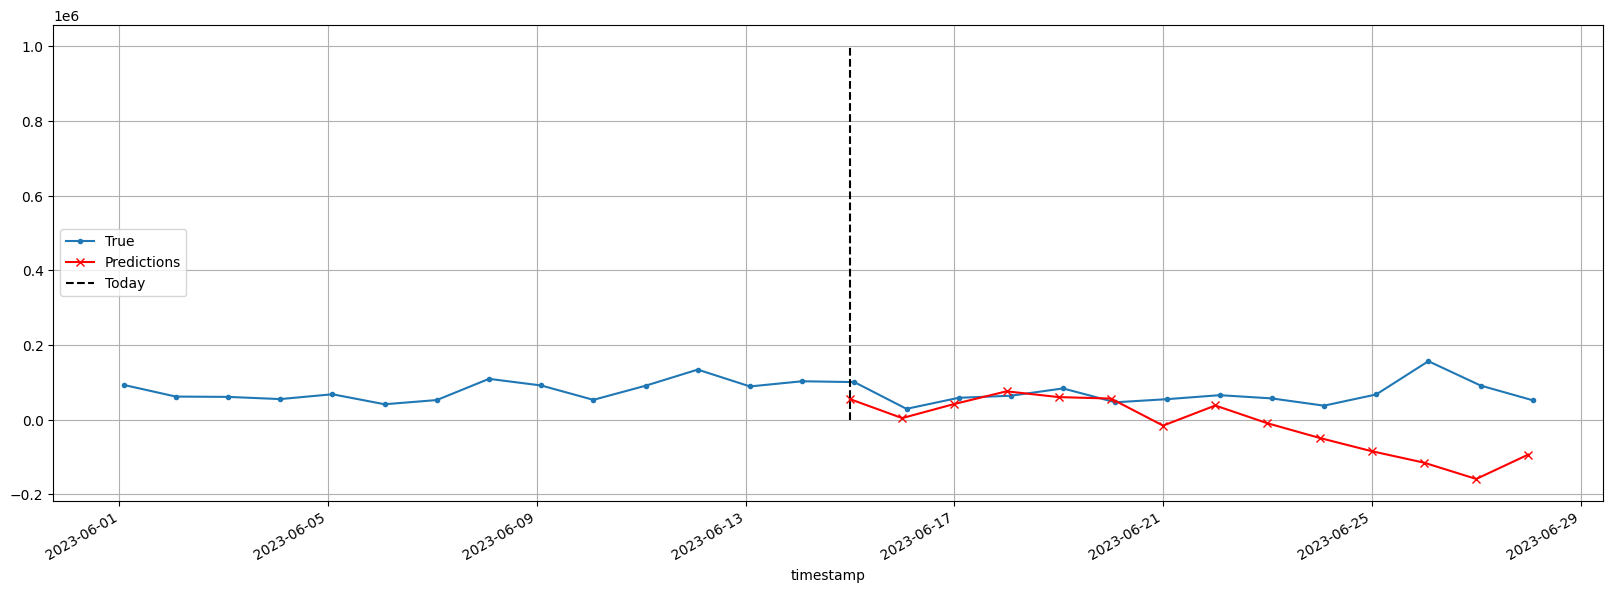

In [25]:
# The forecasts start on 2023-06-01, and they end
# on 2019-06-14. That's 14 days in total.
start = "2023-06-15"
end = "2023-06-28"

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)["2023-06-01":end].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, 0, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()